# Setup and Install

In [ ]:
import os
import glob
import shutil
import random
import gc
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO, RTDETR, settings
from IPython.display import Image, display
from google.colab import drive
from roboflow import Roboflow

In [ ]:
!pip install -q roboflow ultralytics

drive.mount('/content/drive') 

drive_project_root = '/content/drive/MyDrive/Deep_Learning'
drive_weights_dir = os.path.join(drive_project_root, 'weights')
drive_runs_dir = os.path.join(drive_project_root, 'runs')

# Create directories if they don't exist
os.makedirs(drive_weights_dir, exist_ok=True)
os.makedirs(drive_runs_dir, exist_ok=True)

print(f" Setup Complete. GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Setup Complete. GPU Available: True
   GPU Name: NVIDIA A100-SXM4-40GB


# Download and Merge Datasets

In [ ]:
settings.update({'datasets_dir': '/content/datasets'}) # Set datasets directory to Colab local disk for speed at first

def download_data_fast():
    print(" Downloading dataset from Roboflow to local Colab disk")

    rf = Roboflow(api_key="8gFJp7Eu2sWslubjUHwI") # API Key from Roboflow
    project = rf.workspace("visualizan2").project("c1-zhnfm")
    version = project.version(1)

    dataset = version.download("yolov11") # Download in YOLOv11 format

    print(f" Dataset ready at: {dataset.location}")
    return dataset, f"{dataset.location}/data.yaml"


# Execute Download
dataset_obj, data_yaml_path = download_data_fast()

custom_dataset = '/content/custom_dataset' # Path to local dataset we add in Colab

def merge_datasets(source_root, target_root):
    # Iterate through 'train', 'valid', and 'test' sets
    for subset in ['train', 'valid', 'test']:
        for folder in ['images', 'labels']:
            source_dir = os.path.join(source_root, subset, folder)
            target_dir = os.path.join(target_root, subset, folder)

            # Check if source directory exists
            if os.path.exists(source_dir) and os.path.exists(target_dir):
                files = os.listdir(source_dir)
                print(f"--> Copying {len(files)} files to: {subset}/{folder}")

                for file_name in files:
                    full_file_name = os.path.join(source_dir, file_name)
                    if os.path.isfile(full_file_name):
                        shutil.copy(full_file_name, target_dir)
            else:
                pass

# Check if manual path exists and run the merge
if os.path.exists(custom_dataset):
    merge_datasets(custom_dataset, dataset_obj.location)
else:
    print(f"WARNING: local dataset path not found: {custom_dataset}. Proceeding with Roboflow data only.")


loading Roboflow workspace...
loading Roboflow project...
 Dataset ready at: /content/C1-1


## Only Use The Half of The Data

In [ ]:
# Define dataset paths
dataset_root = os.path.dirname(data_yaml_path)
train_images_path = os.path.join(dataset_root, 'train', 'images')
train_labels_path = os.path.join(dataset_root, 'train', 'labels')

# List all training images
all_images = glob.glob(os.path.join(train_images_path, '*.jpg')) + \
             glob.glob(os.path.join(train_images_path, '*.png')) + \
             glob.glob(os.path.join(train_images_path, '*.jpeg'))

print(f"Original Training Set Size: {len(all_images)} images")

# Select 50% of images to delete
percent_to_keep = 0.5
random.seed(42)
random.shuffle(all_images)

num_to_delete = int(len(all_images) * (1 - percent_to_keep))
images_to_delete = all_images[:num_to_delete]

print(f"Images to delete: {len(images_to_delete)} (Remaining: {len(all_images) - len(images_to_delete)})")

# Delete images and corresponding labels
for img_path in images_to_delete:
    try:
        # Remove image
        os.remove(img_path)

        # Remove corresponding label file
        label_name = os.path.basename(img_path).rsplit('.', 1)[0] + '.txt'
        label_path = os.path.join(train_labels_path, label_name)

        if os.path.exists(label_path):
            os.remove(label_path)

    except OSError as e:
        print(f"Error: Could not delete {img_path}. {e}")

print("Dataset successfully reduced by 50%. Ready for training.")

Original Training Set Size: 6831 images
Images to delete: 3415 (Remaining: 3416)
Dataset successfully reduced by 50%. Ready for training.


# Train RT-DETR for 50 epochs

In [ ]:
model_type = 'rtdetr-l.pt'
epochs = 50                 
batch_size = 16           
img_size = 640

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M") # Timestamp for unique run name
run_name = f"chess_rtdetr_l_{timestamp}"

print(f"\n{'='*20} Starting Training: {run_name} {'='*20}")

if torch.cuda.is_available():
    torch.cuda.empty_cache() # Clear GPU cache before training

model = RTDETR(model_type)

# Train
results = model.train(
    data=data_yaml_path,
    epochs=epochs,
    imgsz=img_size,
    batch=batch_size,
    optimizer='AdamW',
    lr0=0.0001,
    cos_lr=True,
    project='/content/runs/detect',
    name=run_name,
    seed=42,
    patience=10,
    plots=True,
    exist_ok=True,
    workers=16
)

print(f"Training Finished. Results saved locally to /content/runs/detect/{run_name}")


==================== Starting Training: chess_rtdetr_l_20251231_1313 ====================
New https://pypi.org/project/ultralytics/8.3.244 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.243 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/C1-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtde

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       1/50      16.3G     0.9934      1.015     0.2625        150        640: 100% ━━━━━━━━━━━━ 214/214 2.3it/s 1:35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 5.0it/s 12.5s
                   all       1960      43525   0.000839     0.0613    0.00495    0.00109

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       2/50      17.1G      0.899     0.9888     0.1802        416        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       2/50      17.1G     0.7809      1.099     0.1501        248        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 5.0it/s 12.3s
                   all       1960      43525     0.0885     0.0647     0.0132     0.0042

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       3/50      17.1G      0.844      1.029     0.1562        435        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       3/50      17.1G     0.7866       1.04     0.1469        251        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.2s
                   all       1960      43525      0.042      0.203     0.0356       0.02

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       4/50      17.1G     0.6218      1.224     0.1199        477        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       4/50      17.1G     0.5435      1.215     0.1119        314        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525     0.0514      0.311     0.0465     0.0288

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       5/50      17.1G     0.5297      1.169     0.1036        435        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       5/50      17.1G      0.512      1.123     0.1055        331        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.116      0.301     0.0744     0.0496

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       6/50      17.1G     0.5313      1.086     0.1202        469        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       6/50      17.1G      0.554      1.041      0.118        250        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525     0.0643      0.445     0.0569     0.0355

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       7/50      17.1G     0.4501      1.184      0.102        497        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       7/50      17.7G     0.5123      1.008     0.1067        277        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525        0.2      0.451      0.174      0.113

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       8/50      17.7G     0.5437      0.905    0.09417        551        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       8/50      17.7G     0.5254      0.823     0.1079        363        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.2s
                   all       1960      43525      0.603      0.621        0.5      0.323

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       9/50      17.7G     0.6269     0.6032     0.1197        565        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       9/50      17.7G     0.5166     0.6359     0.1105        254        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525      0.676      0.661      0.563      0.361

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      10/50      17.7G     0.4219     0.7088    0.09352        263        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      10/50      18.3G     0.5217      0.601     0.1114        291        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.3s
                   all       1960      43525      0.735       0.71       0.62      0.412

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      11/50      18.3G     0.5277     0.6534    0.09327        718        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      11/50      18.3G     0.5079     0.5825     0.1091        295        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.4s
                   all       1960      43525      0.749      0.749      0.663      0.443

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      12/50      18.3G     0.4515     0.5442    0.09938        450        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      12/50      18.3G     0.5053     0.5576     0.1065        262        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.4s
                   all       1960      43525      0.803      0.787      0.729      0.494

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      13/50      18.3G     0.5995     0.4971     0.1442        468        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      13/50      18.3G     0.5175     0.5376     0.1124        178        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.3s
                   all       1960      43525      0.821      0.803      0.747      0.509

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      14/50      18.3G     0.5874     0.4818     0.1179        431        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      14/50      18.3G     0.4959     0.5254     0.1051        362        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.4s
                   all       1960      43525       0.82      0.805      0.758      0.517

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      15/50      18.3G     0.3926     0.4969     0.0807        485        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      15/50      18.3G     0.4875     0.5213     0.1032        283        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.5s
                   all       1960      43525       0.84      0.823      0.779      0.536

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      16/50      18.3G      0.584     0.4741     0.1162        485        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      16/50      18.3G     0.4914      0.507     0.1049        233        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525       0.84      0.826       0.79      0.544

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      17/50      18.3G     0.4902     0.5255    0.09375        482        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      17/50      18.3G     0.4855     0.4993     0.1031        212        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.5s
                   all       1960      43525      0.847      0.826      0.796      0.551

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      18/50      18.3G     0.3823     0.5131    0.07793        495        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      18/50      18.3G     0.4847      0.496     0.1032        395        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.4s
                   all       1960      43525      0.854       0.83      0.809       0.56

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      19/50      18.3G     0.5482     0.4702    0.09733        619        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      19/50      18.3G      0.482     0.4876     0.1025        250        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.5s
                   all       1960      43525      0.861      0.829      0.818      0.569

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      20/50      18.3G     0.5201     0.4662    0.09341        478        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      20/50      18.3G     0.4873     0.4825     0.1017        221        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.4s
                   all       1960      43525      0.866      0.829      0.822       0.57

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      21/50      18.3G     0.6475     0.5278     0.1283        517        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      21/50      19.2G     0.4855     0.4817     0.1006        300        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525      0.877      0.829      0.835       0.58

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      22/50      19.2G     0.4383     0.4828    0.08651        500        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      22/50      19.2G     0.4735     0.4752    0.09942        345        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.4s
                   all       1960      43525      0.886       0.83      0.837      0.584

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      23/50      19.2G     0.3032     0.4336    0.07069        297        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      23/50      19.2G     0.4578     0.4703     0.0941        313        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.3s
                   all       1960      43525      0.887      0.834      0.836      0.586

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      24/50      19.2G      0.506     0.5011    0.09176        521        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      24/50      20.1G     0.4763     0.4727    0.09789        124        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525      0.883      0.833      0.837      0.586

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      25/50      13.6G     0.4485     0.5049    0.09631        462        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      25/50      14.2G     0.4628      0.468    0.09493        155        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525      0.894      0.836      0.841      0.589

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      26/50      14.2G     0.5717     0.4656     0.1474        524        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      26/50      14.4G     0.4572     0.4645     0.0935        170        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.4s
                   all       1960      43525      0.881      0.841      0.825      0.581

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      27/50      14.4G      0.434     0.4188    0.09998        402        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      27/50      15.8G     0.4541     0.4569    0.09311        192        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525      0.893      0.831      0.841      0.592

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      28/50      15.8G     0.4028     0.4461     0.0757        525        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      28/50      16.7G     0.4499     0.4623    0.09174        242        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.4s
                   all       1960      43525      0.894      0.838      0.841      0.592

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      29/50      16.7G      0.429     0.4793    0.08285        476        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      29/50      16.7G     0.4555     0.4632    0.09245        253        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525      0.906      0.831      0.848      0.595

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      30/50      16.7G     0.5974     0.4385     0.1275        410        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      30/50      16.7G     0.4547     0.4566    0.09243        207        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.4s
                   all       1960      43525      0.907       0.81      0.843       0.59

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      31/50      16.7G     0.5138     0.4661     0.1271        503        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      31/50      16.7G     0.4386     0.4545    0.08949        379        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525      0.912      0.825      0.851      0.598

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      32/50      16.7G     0.4459     0.4703     0.0831        594        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      32/50      17.6G     0.4354     0.4529    0.08795        255        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525      0.917      0.822      0.845      0.595

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      33/50      17.6G     0.3855     0.4544    0.07034        555        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      33/50      17.6G     0.4452     0.4534     0.0892        167        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.5s
                   all       1960      43525      0.917       0.83      0.851        0.6

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      34/50      17.6G     0.7215     0.4287     0.1222        467        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      34/50      17.6G     0.4375     0.4475    0.08842        287        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.5it/s 13.7s
                   all       1960      43525      0.915      0.824      0.849      0.595

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      35/50      17.6G     0.3715     0.4469     0.0712        681        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      35/50      18.6G     0.4438     0.4474    0.08872        172        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.2s
                   all       1960      43525      0.917      0.823      0.852      0.601

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      36/50      18.6G     0.3625     0.4719    0.05777        635        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      36/50      18.6G     0.4271     0.4445    0.08652        208        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.2s
                   all       1960      43525      0.896      0.845      0.838      0.593

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      37/50      18.6G     0.3433      0.439    0.05985        426        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      37/50      18.6G     0.4095     0.4427    0.08261        329        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.5s
                   all       1960      43525      0.918      0.827      0.851      0.603

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      38/50      18.6G     0.3808     0.4364    0.06936        493        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      38/50      18.6G     0.4356     0.4447    0.08574        306        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.4s
                   all       1960      43525      0.913      0.831      0.846        0.6

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      39/50      18.6G     0.3375     0.4022    0.05609        476        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      39/50      18.6G      0.431     0.4439    0.08661        204        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525      0.914      0.832      0.851      0.602

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      40/50      18.6G     0.3373     0.4157    0.07254        549        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      40/50      18.6G     0.4225     0.4396    0.08419        264        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.6s
                   all       1960      43525       0.91      0.839      0.848      0.602
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      41/50      18.6G      0.285     0.3768    0.06173        360        640: 0% ──────────── 0/214  1.3s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      41/50      18.6G      0.387     0.4216    0.09008        135        640: 100% ━━━━━━━━━━━━ 214/214 2.5it/s 1:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525       0.91      0.834      0.846      0.599

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      42/50      18.6G     0.4196     0.3891     0.1192        392        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      42/50      18.6G     0.3857     0.4175    0.08944        125        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.3s
                   all       1960      43525      0.913      0.834      0.847        0.6

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      43/50      18.6G     0.3832     0.4407    0.08692        370        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      43/50      18.6G     0.3856      0.416    0.08968        284        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525      0.911      0.837      0.847      0.601

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      44/50      18.6G      0.253     0.3497    0.05904        287        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      44/50      18.6G       0.38     0.4152    0.08755        112        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.4s
                   all       1960      43525      0.918      0.829      0.849      0.603

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      45/50      18.6G     0.2873     0.3885    0.07004        270        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      45/50      18.6G     0.3804     0.4148    0.08833        130        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.4s
                   all       1960      43525      0.919      0.826      0.849        0.6

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      46/50      18.6G     0.2693     0.3697    0.06005        302        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      46/50      18.6G     0.3818     0.4154     0.0885        218        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.5s
                   all       1960      43525      0.917      0.834      0.849      0.603

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      47/50      18.6G     0.2725     0.3528    0.06032        286        640: 0% ──────────── 0/214  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      47/50      18.6G     0.3784     0.4132    0.08688        162        640: 100% ━━━━━━━━━━━━ 214/214 2.6it/s 1:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525      0.918      0.832       0.85      0.603
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 37, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

47 epochs completed in 1.293 hours.
Optimizer stripped from /content/runs/detect/chess_rtdetr_l_20251231_1313/weights/last.pt, 66.3MB
Optimizer stripped from /content/runs/detect/chess_rtdetr_l_20251231_1313/weights/best.pt, 66.3MB

Validating /content/runs/detect/chess_rtdetr_l_20251231_1313/weights/best.pt...
Ultralytics 8.3.243 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A10

In [ ]:
import shutil

def backup_results():
    print("Backing up results to Google Drive")

    local_run_dir = f'/content/runs/detect/{run_name}' 

    drive_dest_dir = os.path.join(drive_runs_dir, run_name)

    if os.path.exists(local_run_dir):
        # Copy the entire folder
        shutil.copytree(local_run_dir, drive_dest_dir)
        print(f"   Full run directory copied to: {drive_dest_dir}")

        # Copy the best weights separately
        local_best_pt = os.path.join(local_run_dir, 'weights', 'best.pt')
        if os.path.exists(local_best_pt):
            drive_weights_path = os.path.join(drive_weights_dir, f"best_{run_name}.pt")
            shutil.copy(local_best_pt, drive_weights_path)
            print(f" Best weights saved to: {drive_weights_path}")

        print("Backup Complete")
    else:
        print(f"Error: Local run directory not found: {local_run_dir}")

backup_results()

'import shutil\n\ndef backup_results():\n    print("Backing up results to Google Drive")\n\n    # Source (Local Colab)\n    local_run_dir = f\'/content/runs/detect/{RUN_NAME}\'\n\n    # Destination (Your Drive)\n    drive_dest_dir = os.path.join(DRIVE_RUNS_DIR, RUN_NAME)\n\n    if os.path.exists(local_run_dir):\n        # 1. Copy the entire folder (logs, csv, plots)\n        shutil.copytree(local_run_dir, drive_dest_dir)\n        print(f"   Full run directory copied to: {drive_dest_dir}")\n\n        # 2. Copy the best weights separately for easy access\n        local_best_pt = os.path.join(local_run_dir, \'weights\', \'best.pt\')\n        if os.path.exists(local_best_pt):\n            drive_weights_path = os.path.join(DRIVE_WEIGHTS_DIR, f"best_{RUN_NAME}.pt")\n            shutil.copy(local_best_pt, drive_weights_path)\n            print(f" Best weights saved to: {drive_weights_path}")\n\n        print("Backup Complete")\n    else:\n        print(f"Error: Local run directory not found: 

## Show Training Metrics

Inspecting results from: /content/drive/MyDrive/Deep_Learning/runs/chess_rtdetr_l_20251231_1313
Test images found in Drive: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images

==================== 1. TRAINING METRICS ====================

--- Loss and Metrics Curves ---


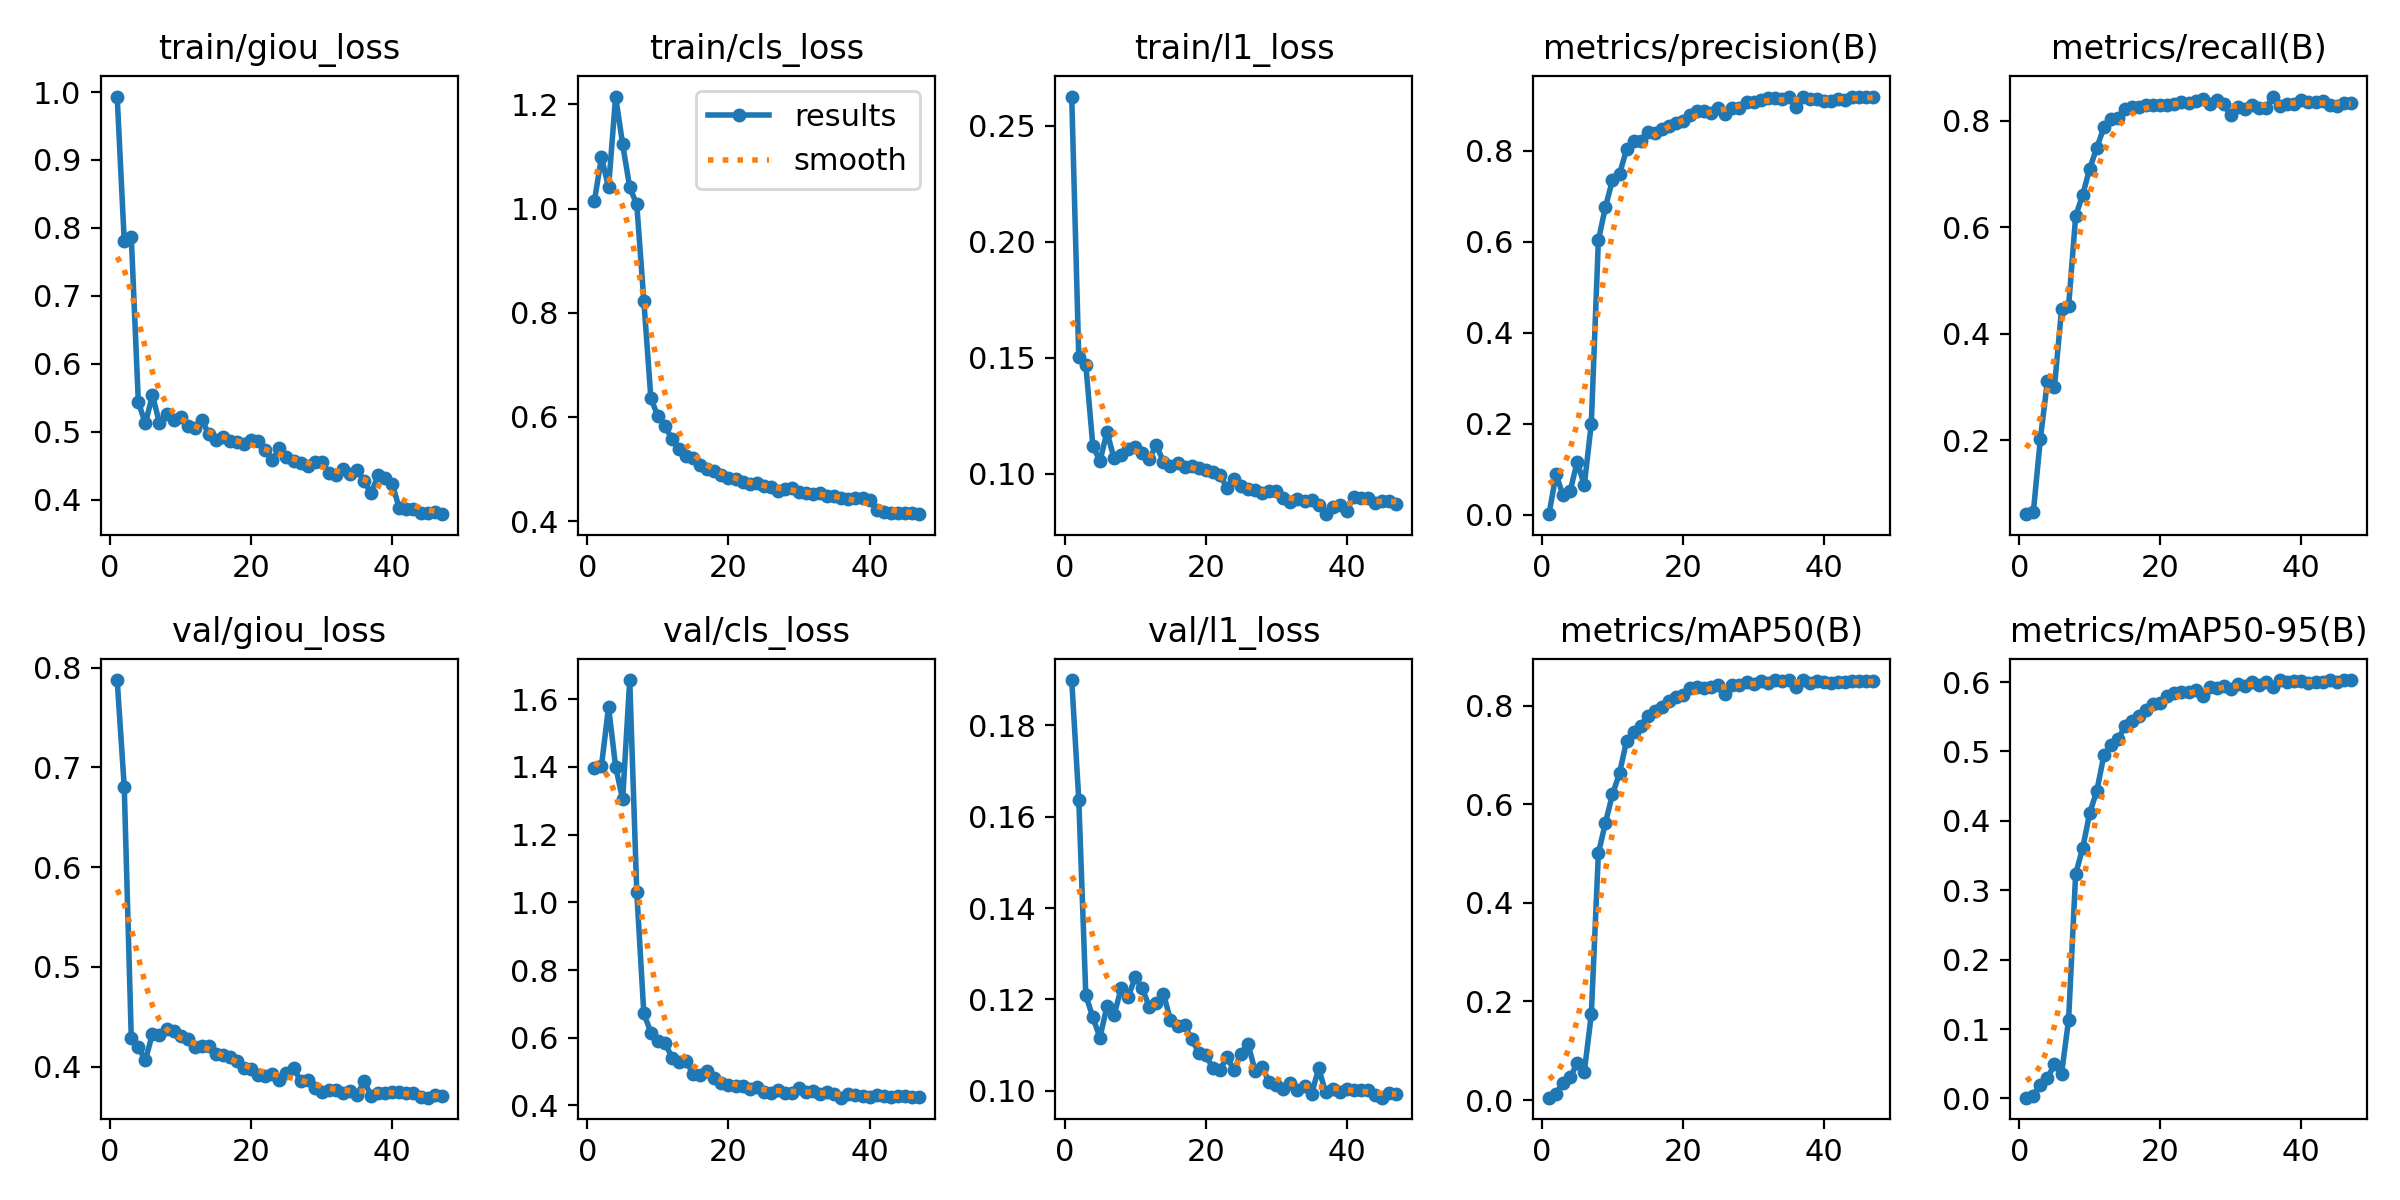


--- Confusion Matrix (Normalized) ---


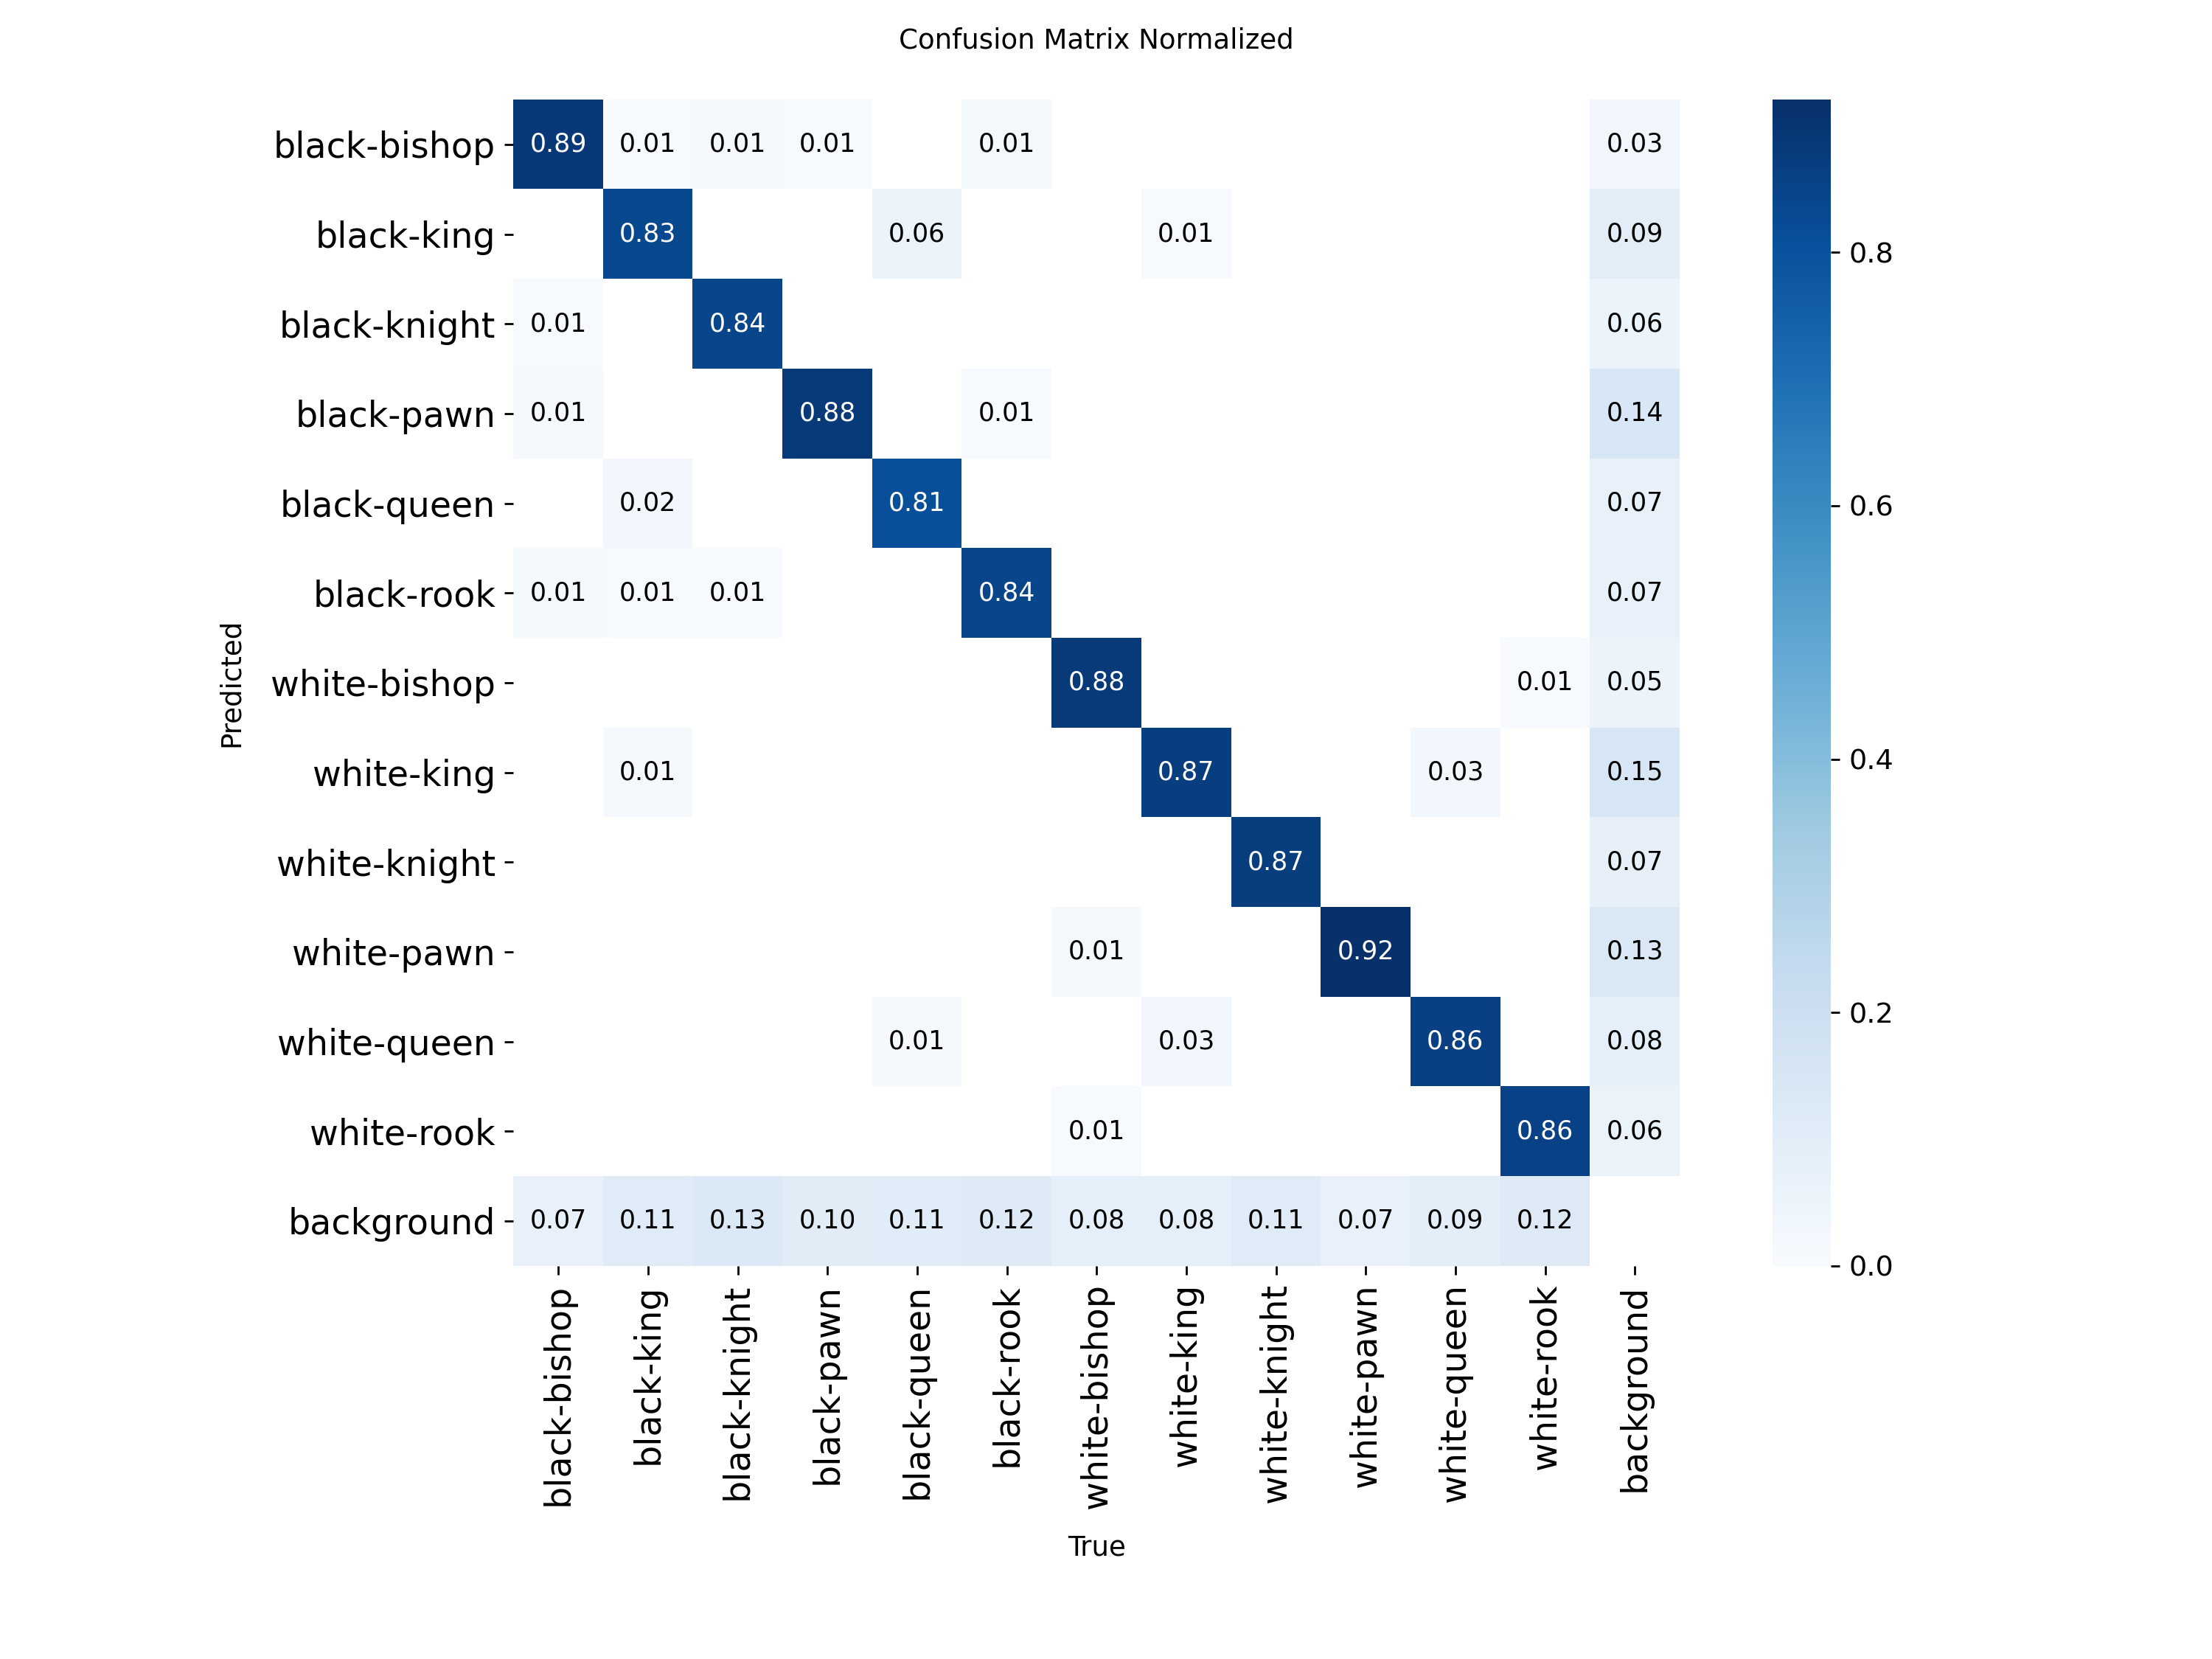


--- Dataset Labels ---


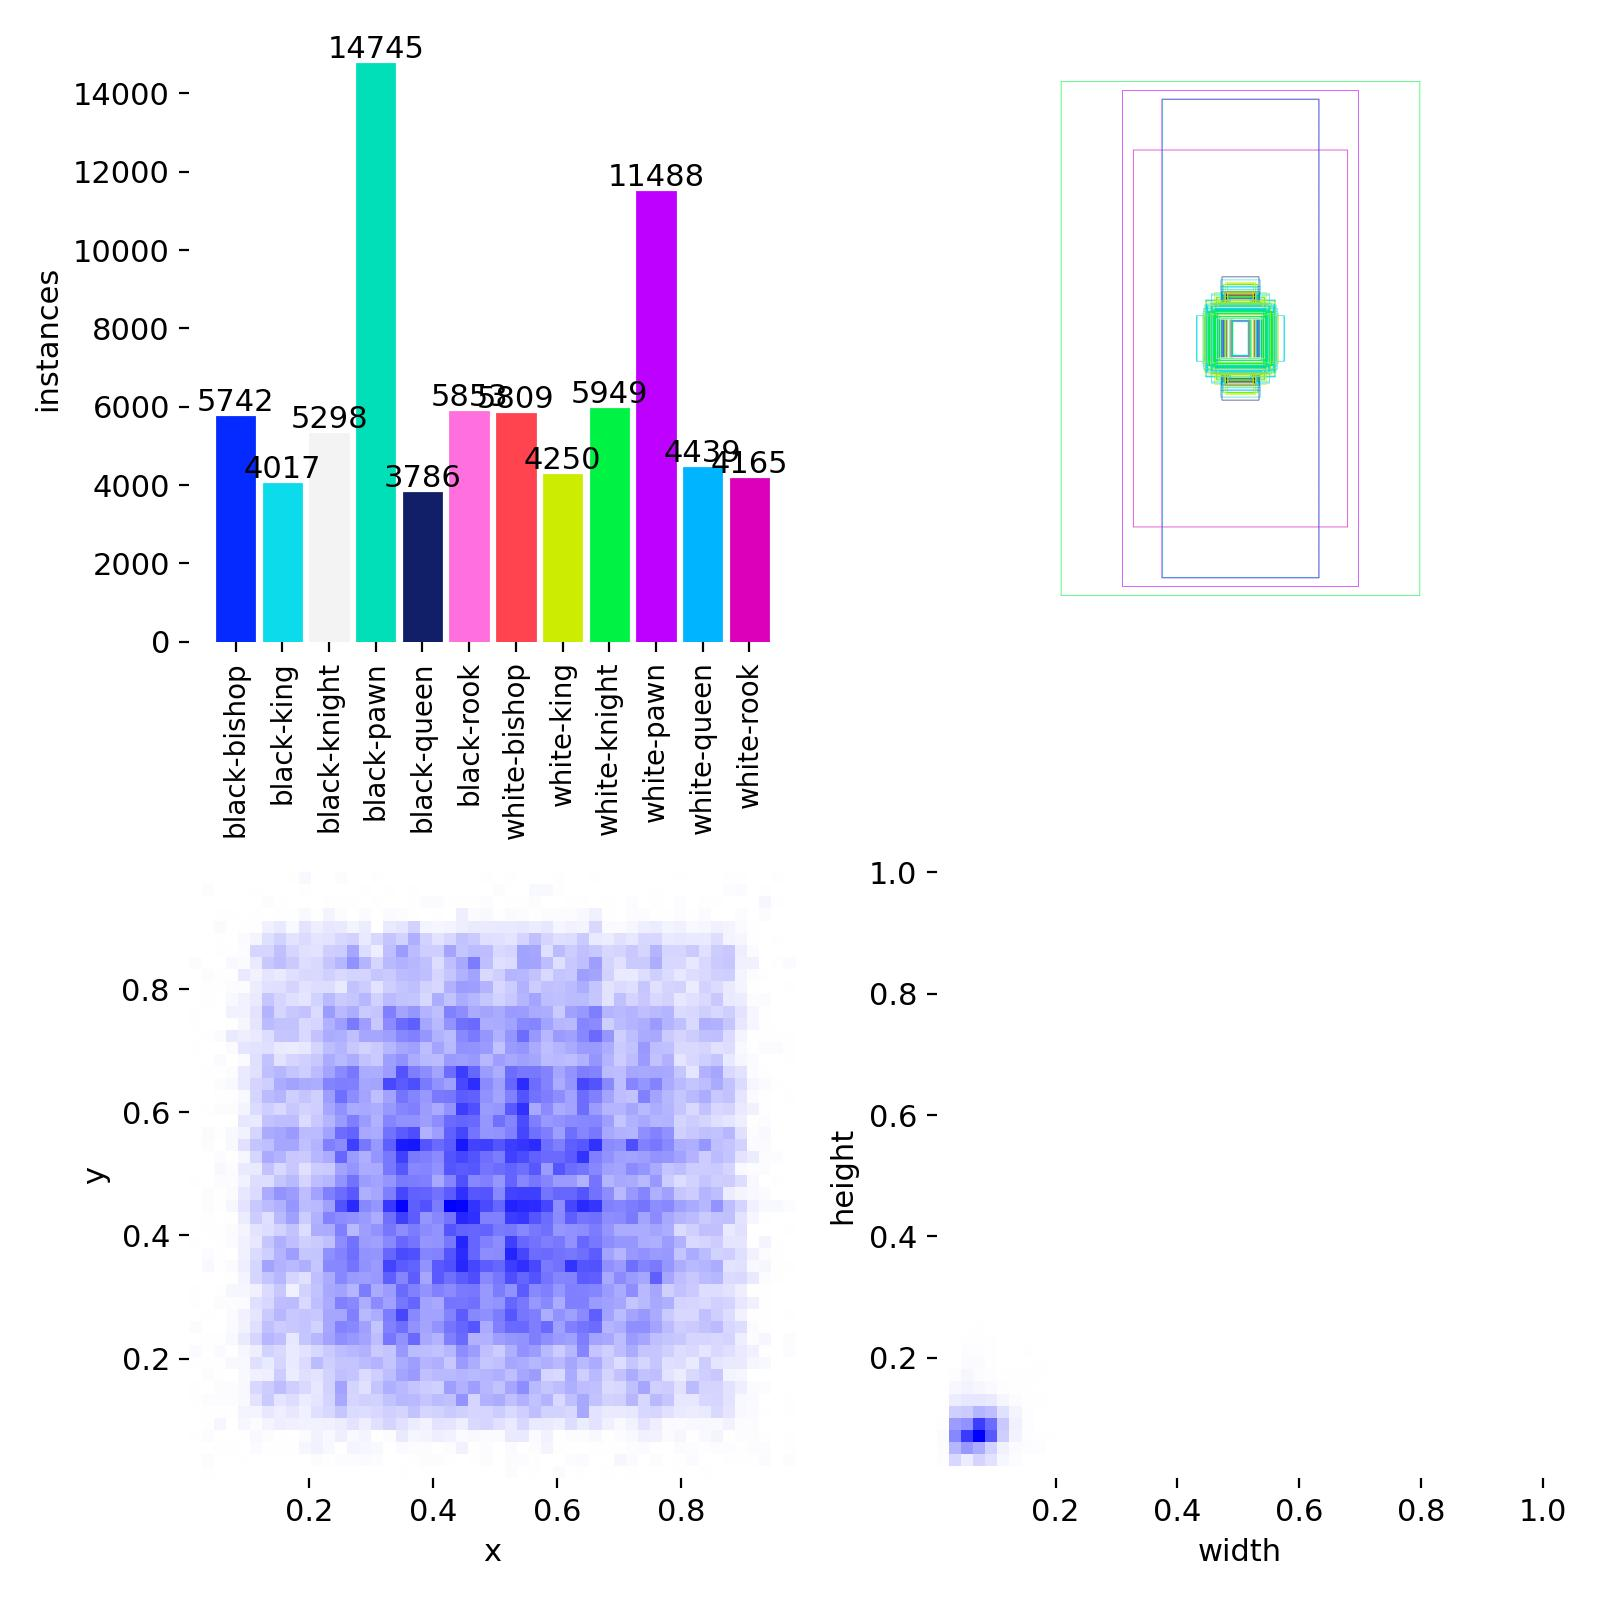


==================== 2. VISUAL PREDICTIONS (TEST SET) ====================


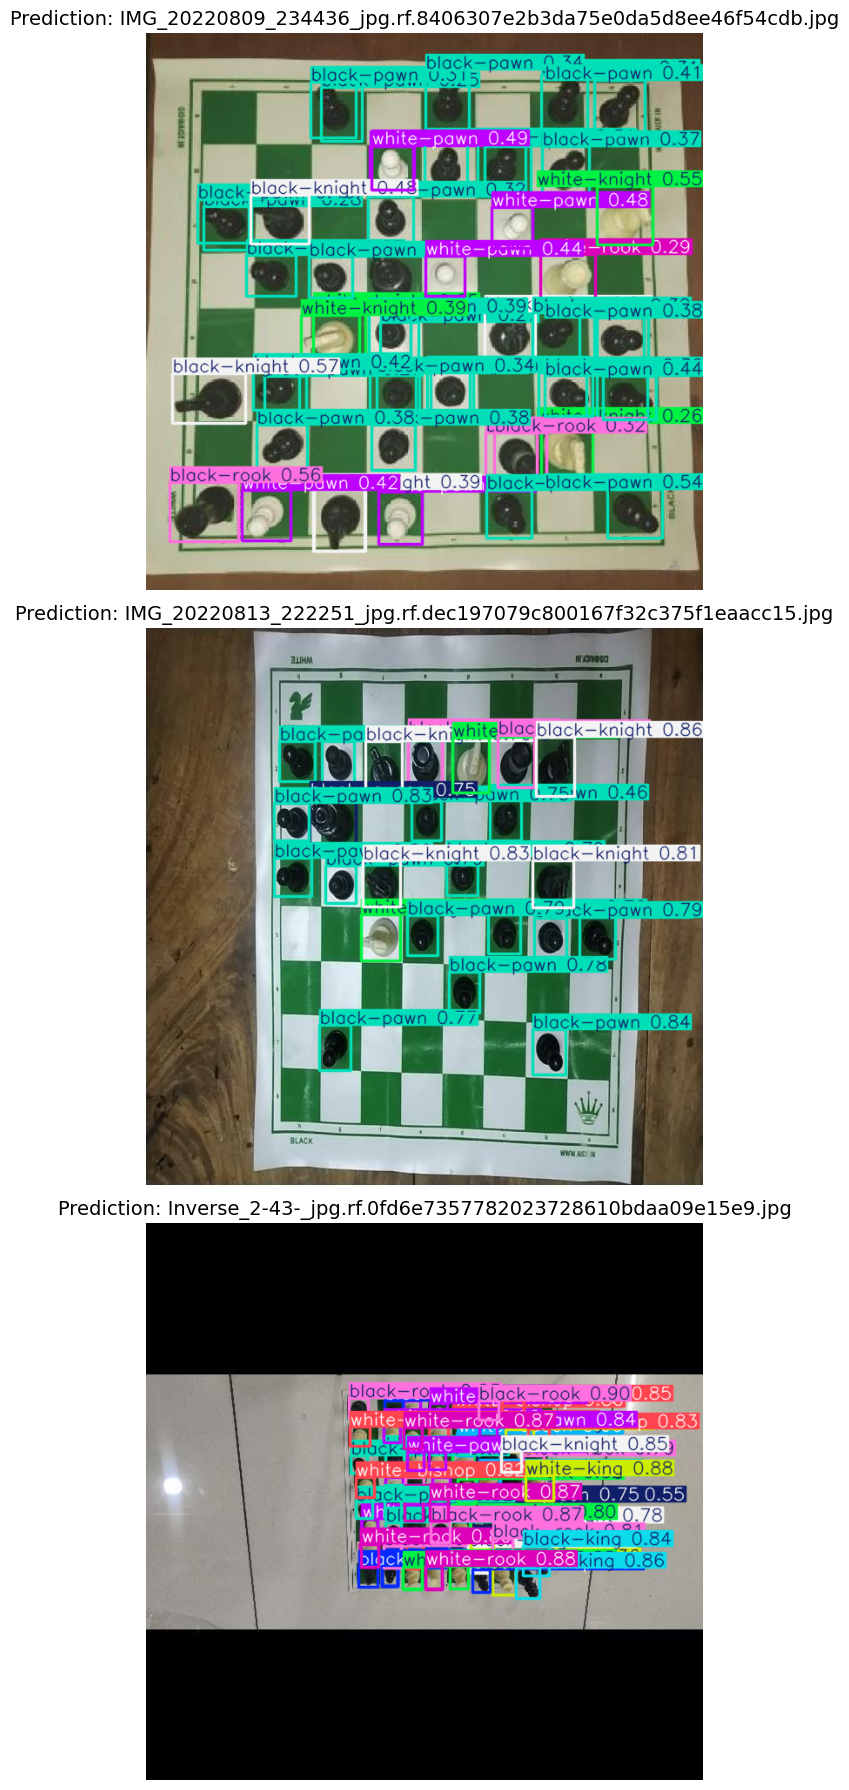

In [ ]:
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

run_name = 'chess_rtdetr_l_20251231_1313' 

# Project root directory on Drive
drive_root = '/content/drive/MyDrive/Deep_Learning'

# Construct full paths
run_dir = os.path.join(drive_root, 'runs', run_name)
best_model_path = os.path.join(run_dir, 'weights', 'best.pt')

print(f"Inspecting results from: {run_dir}")

# Check if run directory exists
if not os.path.exists(run_dir):
    print(f"Error: The folder '{run_name}' was not found in {os.path.join(drive_root, 'runs')}")
    print("Please check the folder name in your Google Drive and update run_name.")
else:
    # Locate test images
    drive_test_search = os.path.join(drive_root, 'datasets', '*', 'test', 'images')
    found_drive_test = glob.glob(drive_test_search)

    if found_drive_test:
        test_images_path = found_drive_test[0]
        print(f"Test images found in Drive: {test_images_path}")
    else:
        # Fallback: local storage
        local_test_path = '/content/datasets/c1-zhnfm-1/test/images'
        if not os.path.exists(local_test_path):
            local_test_path = '/content/datasets/c1-zhnfm-1/valid/images'
        test_images_path = local_test_path

        if os.path.exists(test_images_path):
            print(f"Test images found locally: {test_images_path}")
        else:
            print("Error: Test images could not be found in Drive or local storage.")

    def display_training_metrics(): # Displays standard plots generated by Ultralytics during training.

        print("\n" + "=" * 20 + " 1. TRAINING METRICS " + "=" * 20)

        # Standard Ultralytics output plots
        plots_to_show = [
            ('results.png', 'Loss and Metrics Curves'),
            ('confusion_matrix_normalized.png', 'Confusion Matrix (Normalized)'),
            ('labels.jpg', 'Dataset Labels')
        ]

        for filename, title in plots_to_show:
            filepath = os.path.join(run_dir, filename)
            if os.path.exists(filepath):
                print(f"\n--- {title} ---")
                display(Image(filename=filepath, width=800))
            else:
                print(f"WARNING: {filename} was not found. It may only be generated at the end of training.")

    def run_visual_inference(num_images=3):
        
        print("\n" + "=" * 20 + " 2. VISUAL PREDICTIONS (TEST SET) " + "=" * 20)

        # Check if weights exist
        if not os.path.exists(best_model_path):
            print(f"Error: Best model weights not found at: {best_model_path}")
            return

        # The YOLO class can load RT-DETR weights for inference
        model = YOLO(best_model_path)

        # Collect test images
        all_images = glob.glob(f"{test_images_path}/*.jpg")

        if len(all_images) == 0:
            print(f"Error: No images found in {test_images_path}")
            return

        # Randomly select images
        selected_images = random.sample(all_images, min(len(all_images), num_images))

        # Run inference
        results = model.predict(
            source=selected_images,
            conf=0.25,
            iou=0.45,
            save=False,
            verbose=False
        )

        # Display predictions
        plt.figure(figsize=(15, 6 * num_images))

        for i, r in enumerate(results):
            im_bgr = r.plot(line_width=2, font_size=2)
            im_rgb = im_bgr[..., ::-1]  # Convert BGR to RGB

            plt.subplot(num_images, 1, i + 1)
            plt.imshow(im_rgb)
            plt.axis('off')
            plt.title(f"Prediction: {os.path.basename(selected_images[i])}", fontsize=14)

        plt.tight_layout()
        plt.show()

    display_training_metrics()
    run_visual_inference(num_images=3)


## Analyse Model Confidence

Loading model from: /content/drive/MyDrive/Deep_Learning/runs/chess_rtdetr_l_20251231_1313/weights/best.pt
Analyzing images in: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images
Processing 976 images sequentially to save memory...


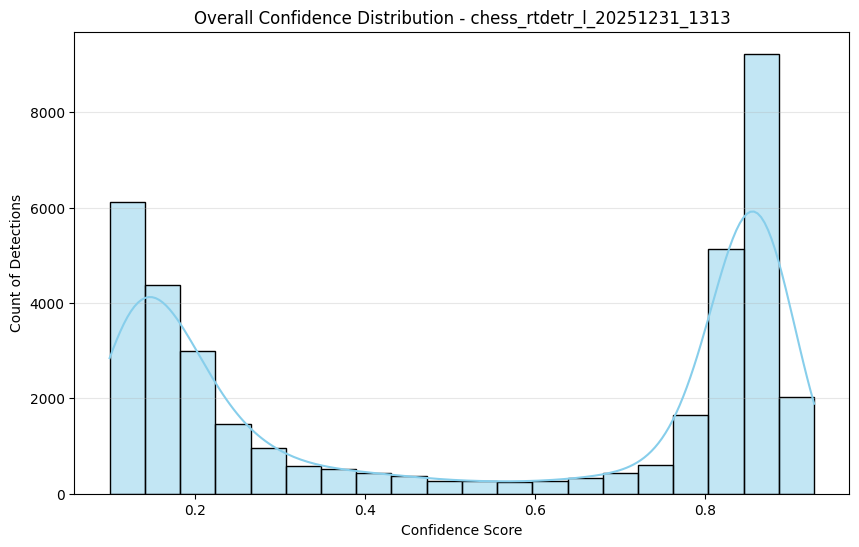



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



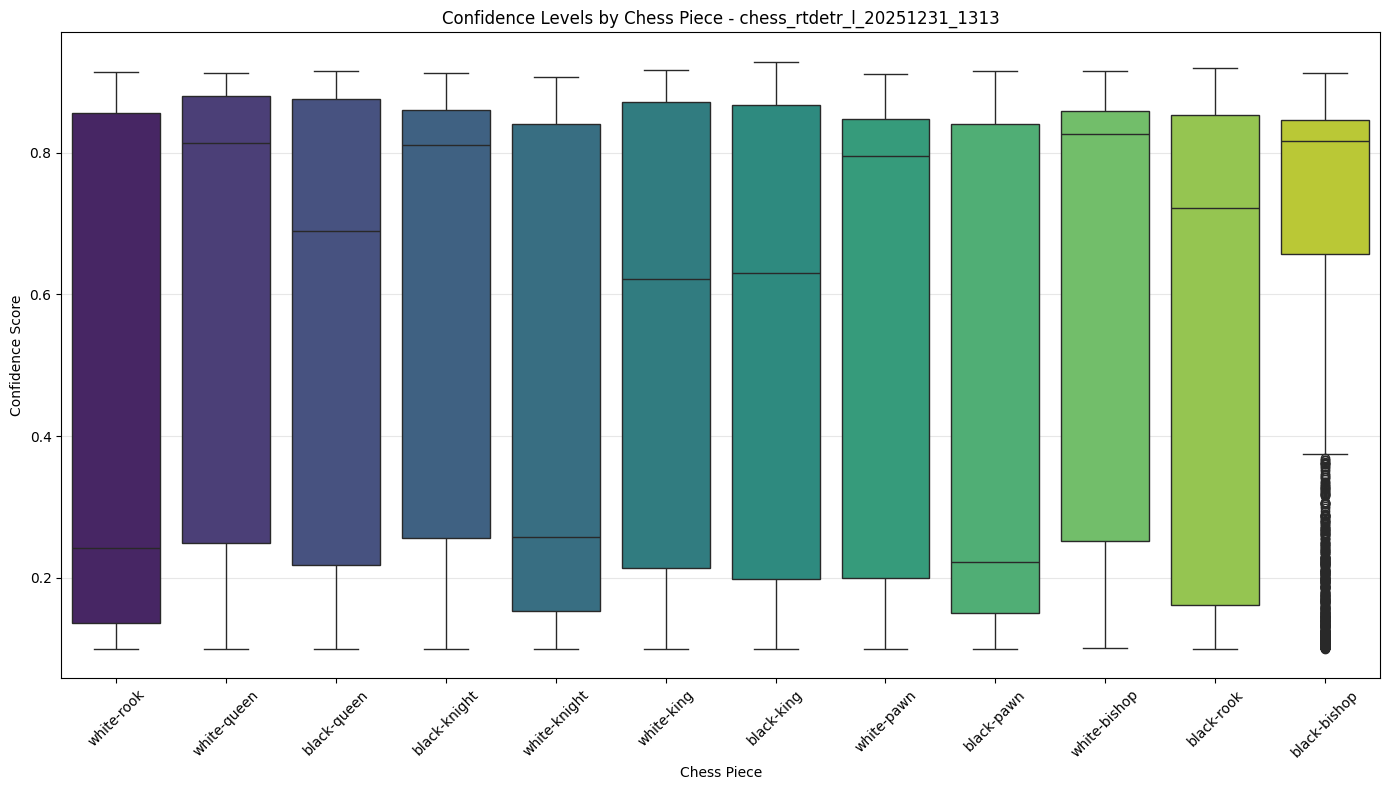

In [ ]:
run_name = 'chess_rtdetr_l_20251231_1313'

drive_root = '/content/drive/MyDrive/Deep_Learning'
run_dir = os.path.join(drive_root, 'runs', run_name)
best_model_path = os.path.join(run_dir, 'weights', 'best.pt')

# Locate Test Images
drive_test_search = os.path.join(drive_root, 'datasets', '*', 'test', 'images')
found_drive_test = glob.glob(drive_test_search)

if found_drive_test:
    test_image_dir = found_drive_test[0]
else:
    test_image_dir = '/content/datasets/c1-zhnfm-1/test/images'
    if not os.path.exists(test_image_dir):
        test_image_dir = '/content/datasets/c1-zhnfm-1/valid/images'

def plot_confidence_analysis(model_path, images_dir):
    # Clear Memory Before Starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    if not os.path.exists(model_path):
        print(f"Error: Model weights not found at {model_path}")
        return

    print(f"Loading model from: {model_path}")
    print(f"Analyzing images in: {images_dir}")

    # Load Model
    model = YOLO(model_path)
    image_files = glob.glob(f"{images_dir}/*.jpg")

    if not image_files:
        print("No images found.")
        return

    # Collect data
    all_confs = []
    all_classes = []

    print(f"Processing {len(image_files)} images sequentially to save memory...")

    # We loop through files manually to ensure memory is released after each image
    for i, img_path in enumerate(image_files):
        try:
            results = model.predict(img_path, conf=0.1, verbose=False, device=0)

            for r in results:
                if r.boxes:
                    confs = r.boxes.conf.cpu().numpy()
                    clss = r.boxes.cls.cpu().numpy().astype(int)
                    class_names = r.names

                    all_confs.extend(confs)
                    all_classes.extend([class_names[c] for c in clss])
        except Exception as e:
            print(f"Skipping image {i} due to error: {e}")
            continue

    # Create DataFrame for plotting
    df = pd.DataFrame({'Confidence': all_confs, 'Class': all_classes})

    if df.empty:
        print("No detections made on the test set.")
        return

    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='Confidence', bins=20, kde=True, color='skyblue')
    plt.title(f'Overall Confidence Distribution - {run_name}')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count of Detections')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # Boxplot
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='Class', y='Confidence', palette='viridis')
    plt.xticks(rotation=45)
    plt.title(f'Confidence Levels by Chess Piece - {run_name}')
    plt.xlabel('Chess Piece')
    plt.ylabel('Confidence Score')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_confidence_analysis(best_model_path, test_image_dir)

## Advanced Evaluation

Analysis started for run: chess_rtdetr_l_20251231_0644
Model path: /content/drive/MyDrive/Deep_Learning/runs/chess_rtdetr_l_20251231_0644/weights/best.pt
Test Images: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images

Computing class-wise mAP...
Ultralytics 8.3.243 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
rt-detr-l summary: 310 layers, 32,008,400 parameters, 0 gradients, 103.5 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 27.1±10.7 MB/s, size: 50.9 KB)
val: Scanning /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/labels.cache... 976 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 976/976 1.3Mit/s 0.0s
val: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images/IMG_20200909_000652_jpg.rf.915eb2770aef574ef4eae9a12de1e2b8.jpg: 2 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 61/61 7.5it/s 8.1s
               



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



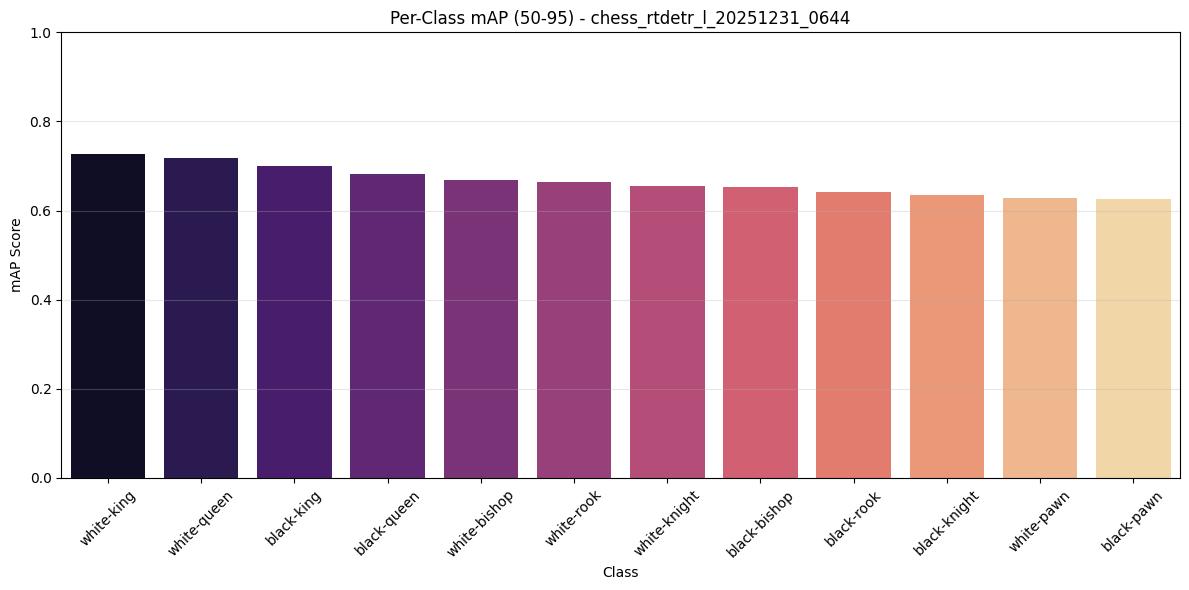


--- Confusion Matrix ---


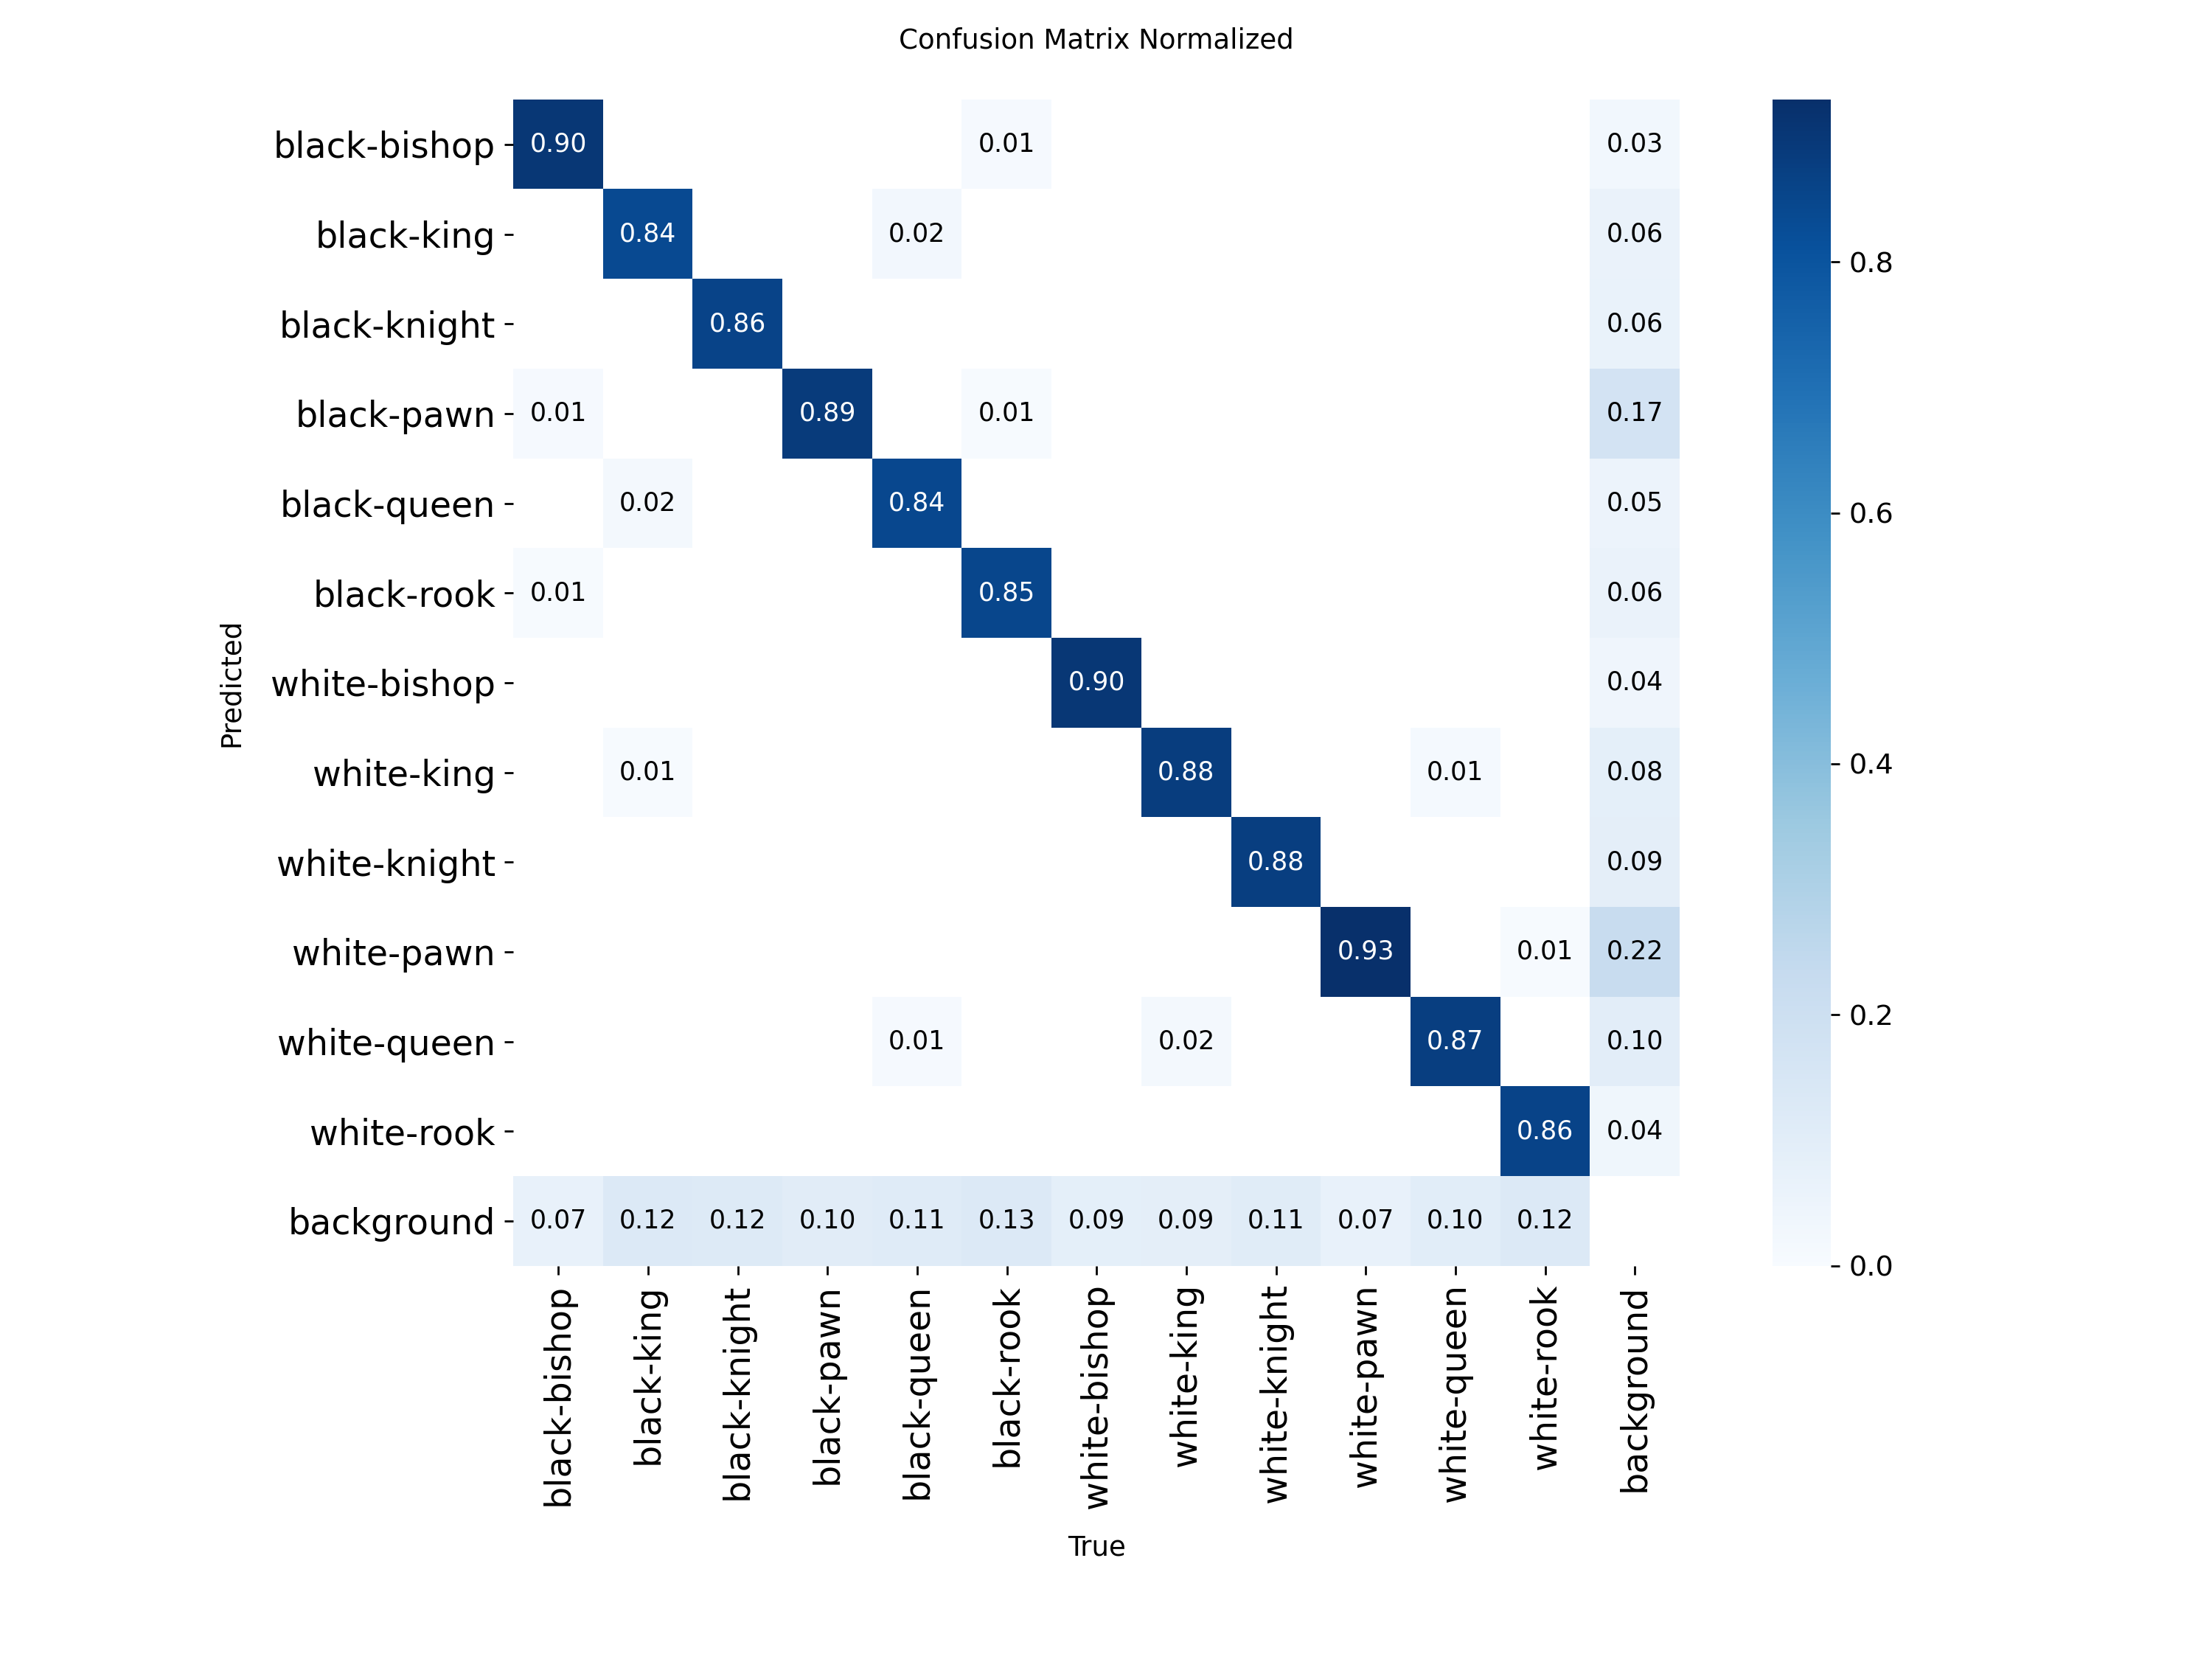


--- 1. Class Distribution Analysis (Ground Truth) ---




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



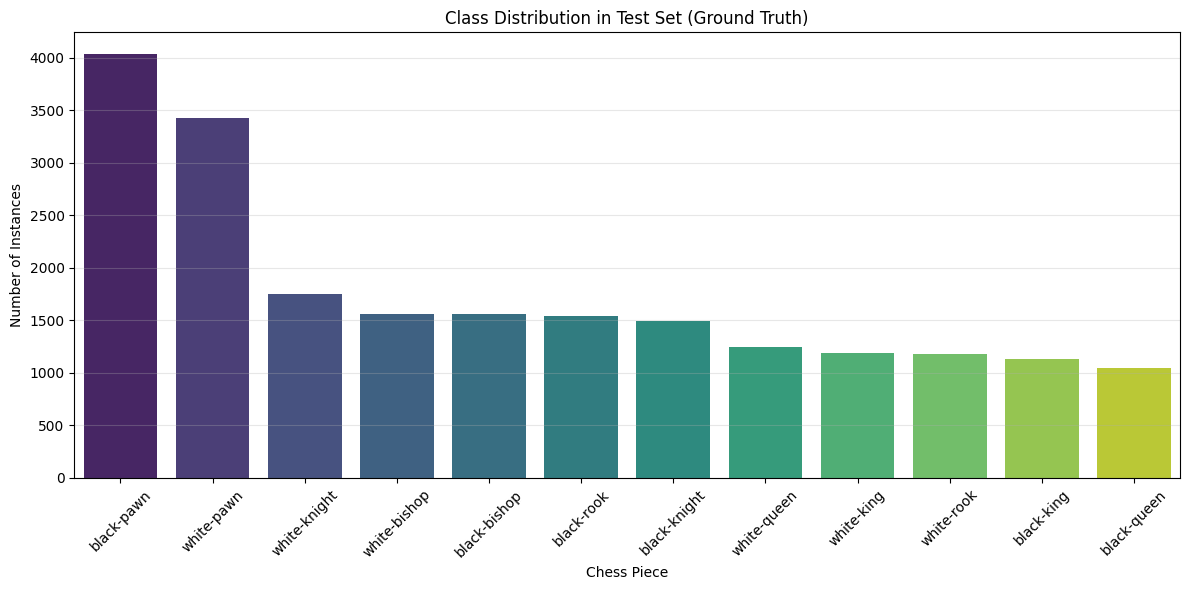


--- 2. Worst Predictions Gallery (Lowest Confidence) ---
Running sequential inference to find hard samples (Memory Safe)...
Plotting 6 worst cases...


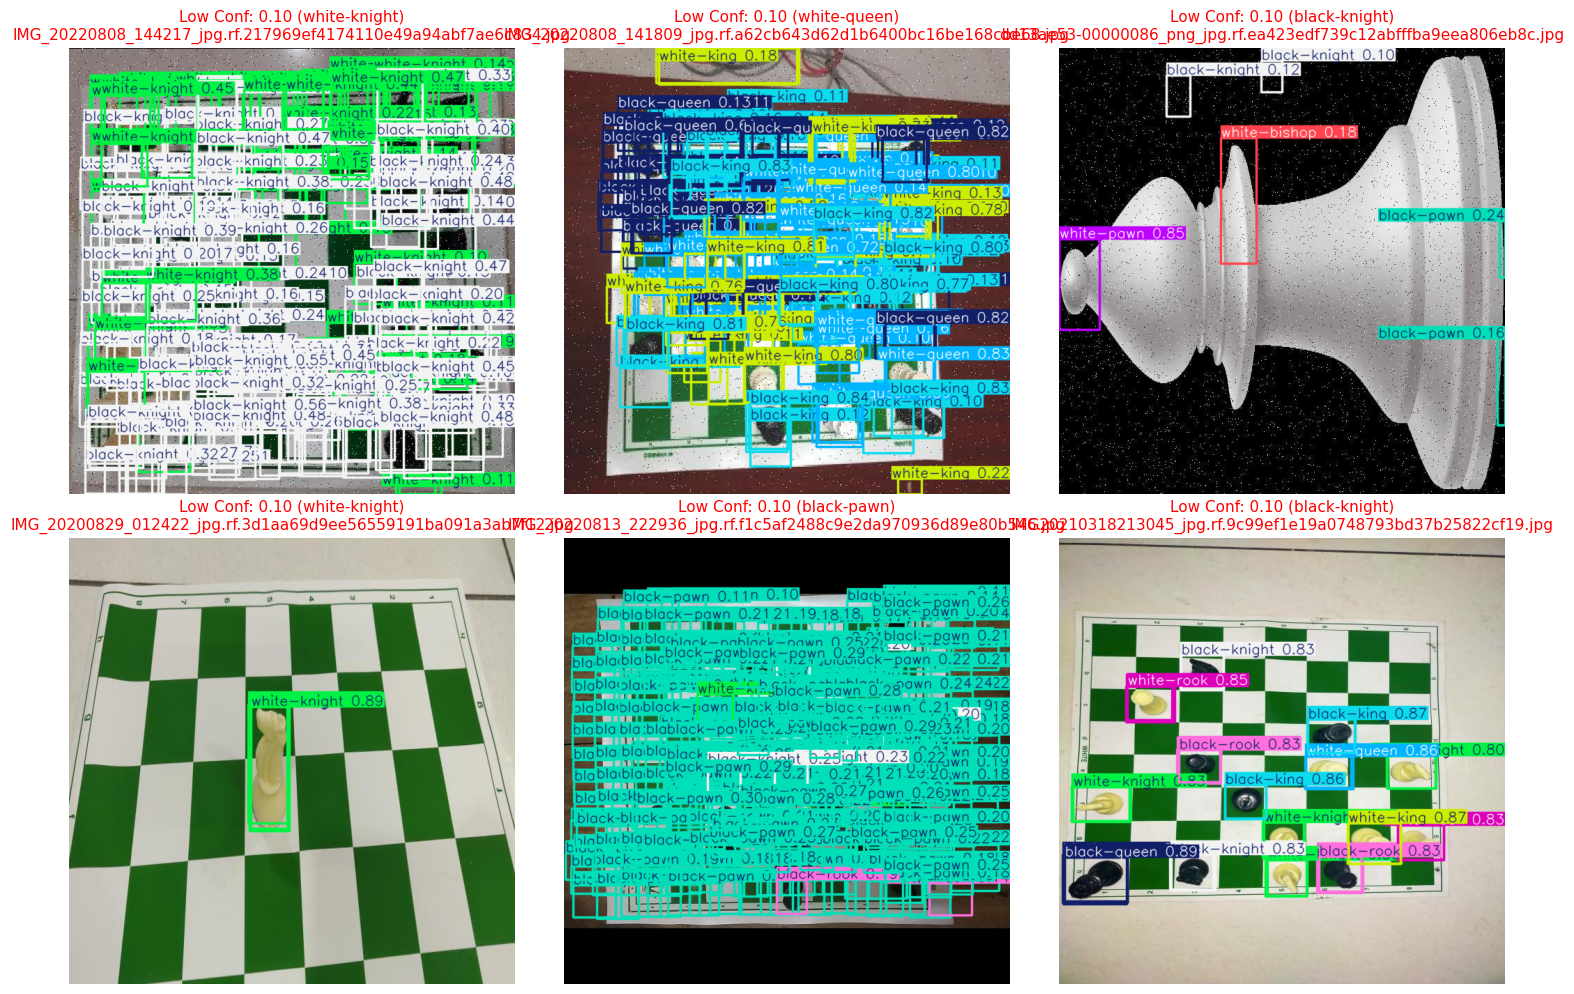

In [ ]:
run_name = 'chess_rtdetr_l_20251231_1313'

drive_root = '/content/drive/MyDrive/Deep_Learning'
run_dir = os.path.join(drive_root, 'runs', run_name)
best_model_path = os.path.join(run_dir, 'weights', 'best.pt')

# Locate Images and Labels
drive_test_search = os.path.join(drive_root, 'datasets', '*', 'test', 'images')
found_drive_test = glob.glob(drive_test_search)

if found_drive_test:
    test_image_dir = found_drive_test[0]
else:
    test_image_dir = '/content/datasets/c1-zhnfm-1/test/images'
    if not os.path.exists(test_image_dir):
        test_image_dir = '/content/datasets/c1-zhnfm-1/valid/images'

TEST_LABELS_DIR = test_image_dir.replace('images', 'labels')

print(f"Analysis started for run: {run_name}")
print(f"Model path: {best_model_path}")
print(f"Test Images: {test_image_dir}")

def analyze_class_distribution(class_names): # Analyzes and plots the class distribution from ground truth labels in the test set.

    print("\n1. Class Distribution Analysis (Ground Truth)")

    label_files = glob.glob(os.path.join(TEST_LABELS_DIR, "*.txt"))
    if not label_files:
        print("No label files found. Skipping distribution plot.")
        return

    class_counts = Counter()

    for lf in label_files:
        with open(lf, 'r') as f:
            lines = f.readlines()
            for line in lines:
                try:
                    cls_id = int(line.split()[0])
                    # Map ID to name using the model's class names
                    if cls_id < len(class_names):
                        class_counts[class_names[cls_id]] += 1
                except ValueError:
                    continue

    if not class_counts:
        print("No classes found in label files.")
        return

    # Create DataFrame
    df_dist = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count']).reset_index()
    df_dist.columns = ['Class', 'Count']
    df_dist = df_dist.sort_values('Count', ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_dist, x='Class', y='Count', palette='viridis')
    plt.title('Class Distribution in Test Set (Ground Truth)')
    plt.xlabel('Chess Piece')
    plt.ylabel('Number of Instances')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def generate_advanced_plots():
    # Clear GPU memory before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    if not os.path.exists(best_model_path):
        print("Model file not found.")
        return

    # Load Model
    model = YOLO(best_model_path)

    # Standard Metrics (mAP)
    print("\nComputing class-wise mAP")
    # Run validation
    metrics = model.val(
        data=os.path.join(os.path.dirname(os.path.dirname(test_image_dir)), 'data.yaml'),
        split='test',
        verbose=False,
        plots=False
    )

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    class_names = metrics.names
    map5095_per_class = metrics.box.maps

    df_map = pd.DataFrame({
        'Class': [class_names[i] for i in range(len(map5095_per_class))],
        'mAP 50-95': map5095_per_class
    }).sort_values('mAP 50-95', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_map, x='Class', y='mAP 50-95', palette='magma')
    plt.title(f'Per-Class mAP (50-95) - {run_name}')
    plt.xlabel('Class')
    plt.ylabel('mAP Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    conf_matrix_path = os.path.join(run_dir, 'confusion_matrix_normalized.png')
    if os.path.exists(conf_matrix_path):
        print("\n--- Confusion Matrix ---")
        display(Image(filename=conf_matrix_path, width=800))
        
    # Class Distribution
    analyze_class_distribution(class_names)


generate_advanced_plots()

## Visualize the Results on the Images we took

In [ ]:
custom_images_path = '/content/drive/MyDrive/Deep_Learning/Custom_images'

yolo_weights_path = '/content/drive/MyDrive/Deep_Learning/runs/chess_yolo11s_fast_v1_20251224_1304/weights/best.pt'

detr_weights_path = '/content/drive/MyDrive/Deep_Learning/runs/chess_rtdetr_l_20251231_1313/weights/best.pt'

conf_threshold = 0.5


def run_comparative_inference():
    # Check paths
    if not os.path.exists(custom_images_path):
        print(f"Error: Image folder not found at {custom_images_path}")
        return
    if not os.path.exists(yolo_weights_path):
        print(f"Error: YOLO weights not found at {yolo_weights_path}")
        return
    if not os.path.exists(detr_weights_path):
        print(f"Error: DETR weights not found at {detr_weights_path}")
        return

    # Load Models
    print("Loading models.")
    try:
        yolo_model = YOLO(yolo_weights_path)

        try:
            detr_model = RTDETR(detr_weights_path)
        except:
            detr_model = YOLO(detr_weights_path) # Fallback

        print("Models loaded successfully.")
    except Exception as e:
        print(f"Error loading models: {e}")
        return

    # Get Images
    image_files = glob.glob(os.path.join(custom_images_path, "*.*"))
    # Filter for valid image extensions
    valid_exts = ['.jpg', '.jpeg']
    image_files = [f for f in image_files if os.path.splitext(f)[1].lower() in valid_exts]

    if not image_files:
        print(f" No images found in {custom_images_path}")
        return

    print(f"Found {len(image_files)} images. Starting inference\n")

    # Inference & Visualization Loop
    for i, img_path in enumerate(image_files):
        filename = os.path.basename(img_path)
        print(f"Processing image {i+1}/{len(image_files)}: {filename}")

        # Run Inference
        # device=0 ensures GPU usage
        yolo_results = yolo_model.predict(img_path, conf=conf_threshold, verbose=False, device=0)
        detr_results = detr_model.predict(img_path, conf=conf_threshold, verbose=False, device=0)

        # Plotting Setup (1 Row, 3 Columns)
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))

        # A. Original Image (Read via matplotlib)
        img_original = plt.imread(img_path)
        axes[0].imshow(img_original)
        axes[0].set_title("Original Image", fontsize=16)
        axes[0].axis('off')

        # B. YOLO Prediction
        # plot() returns BGR numpy array, convert to RGB
        yolo_plot = yolo_results[0].plot(line_width=1, font_size=1)
        axes[1].imshow(yolo_plot[..., ::-1])
        axes[1].set_title(f"YOLOv11 Prediction\n({os.path.basename(yolo_weights_path)})", fontsize=16, color='blue')
        axes[1].axis('off')

        # RT-DETR Prediction
        detr_plot = detr_results[0].plot(line_width=1, font_size=1)
        axes[2].imshow(detr_plot[..., ::-1])
        axes[2].set_title(f"RT-DETR(50 Epoch) Prediction\n({os.path.basename(detr_weights_path)})", fontsize=16, color='purple')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()
        print("-" * 80)

run_comparative_inference()

# WE DELETED THE OUTPUT OF THE CELL SINCE OUR TOTAL FILE SIZE EXCEEDED 50 MB